In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path
from typing import Optional

import arviz as az
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
# from hb_mep.models.rats import MixtureModel
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)


import logging
from typing import Optional

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

from hb_mep.config import HBMepConfig
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site
from hb_mep.utils import timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

""" Load """
dir_name = "physio2"
dir = os.path.join(data.data_path, dir_name)

participants = range(3, 4)

df, mat, time = load_data(dir=dir, participants=participants)

""" Custome filter """
idx = df.compound_position.isin(["-C6LE", "C6LN-C6LC"])
df = df[idx].copy()
mat = mat[idx, :, :]

""" Preprocess """
df, encoder_dict, mat = data.build(df=df, mat=mat)

2023-06-26 11:13:35,334 - hb_mep.utils.utils - INFO - func:load_data took: 0.17 sec
2023-06-26 11:13:35,339 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-26 11:13:35,344 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-06-26 11:13:35,344 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


In [5]:
# plot(df=df, encoder_dict=encoder_dict, mat=mat, time=time)

### Mixture Model

In [6]:
class MixtureModel(Baseline):
    def __init__(self, config: HBMepConfig):
        super(MixtureModel, self).__init__(config=config)
        self.name = "MixtureModel"

        self.columns = [PARTICIPANT] + FEATURES
        self.x = np.linspace(0, 800, 2000)

    def _model(self, intensity, participant, feature0, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        n_data = intensity.shape[0]
        n_participant = np.unique(participant).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate("n_response", self.n_response, dim=-1):
            with numpyro.plate("n_participant", n_participant, dim=-2):
                """ Hyper-priors """
                a_mean = numpyro.sample(
                    site.a_mean,
                    dist.TruncatedNormal(150, 50, low=0)
                )
                a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(50))

                b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(0.1))

                h_scale = numpyro.sample("h_scale", dist.HalfNormal(5))
                v_scale = numpyro.sample("v_scale", dist.HalfNormal(10))

                lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.05))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(b_scale))

                    h = numpyro.sample("h", dist.HalfNormal(h_scale))
                    v = numpyro.sample("v", dist.HalfNormal(v_scale))

                    lo = numpyro.sample(site.lo, dist.HalfNormal(lo_scale))

                    gamma_scale_offset = numpyro.sample(
                        "gamma_scale_offset", dist.HalfCauchy(2.5)
                    )
                    gamma_scale_slope = numpyro.sample(
                        "gamma_scale_slope", dist.HalfCauchy(2.5)
                    )

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature0, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature0, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature0, participant], v[feature0, participant]) - 1) * \
                    jnp.exp(-b[feature0, participant] * (intensity - a[feature0, participant])),
                    1 / v[feature0, participant]
                )
            )
        )

        scale = numpyro.deterministic(
            "scale",
            gamma_scale_offset[feature0, participant] + \
            gamma_scale_slope[feature0, participant] * (1 / mean)
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(mean * scale, scale).to_event(1),
                obs=response_obs
            )

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy()
        self.n_response = response.shape[-1]

        intensity = df[INTENSITY].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature0 = df[FEATURES[0]].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        # logger.info(f"Running inference with {self.name} ...")
        mcmc.run(rng_key, intensity, participant, feature0, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples

    def _get_threshold_estimates(
        self,
        combination: tuple,
        posterior_samples: dict,
        prob: float = .95
    ):
        threshold_posterior = posterior_samples[site.a][
            :, combination[1], combination[0], :
        ]
        threshold = threshold_posterior.mean(axis=0)
        hpdi_interval = hpdi(threshold_posterior, prob=prob)
        return threshold, threshold_posterior, hpdi_interval

    def predict(
        self,
        intensity: np.ndarray,
        combination: tuple,
        posterior_samples: Optional[dict] = None,
        num_samples: int = 100
    ):
        predictive = Predictive(model=self._model, num_samples=num_samples)
        if posterior_samples is not None:
            predictive = Predictive(model=self._model, posterior_samples=posterior_samples)

        participant = np.repeat([combination[0]], intensity.shape[0])
        feature0 = np.repeat([combination[1]], intensity.shape[0])

        predictions = predictive(
            self.rng_key,
            intensity=intensity,
            participant=participant,
            feature0=feature0
        )
        return predictions


In [12]:
muscle = "auc_3"
int(muscle.split("_")[1]) - 1

2

#### Initialize model

In [7]:
model = MixtureModel(config)

2023-06-26 11:13:35,444 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-26 11:13:35,444 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-26 11:13:35,445 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-26 11:13:35,446 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-26 11:13:35,446 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


#### Run MCMC inference

In [8]:
mcmc, posterior_samples = model.run_inference(df=df)

NameError: name 'logger' is not defined

#### Diagnostics

In [ ]:
mcmc.print_summary(prob=.95)


                               mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0,0]    101.55      1.02    101.61     99.67    103.41  13205.69      1.00
                 a[1,0,0]     51.66      2.20     51.59     46.98     54.65    933.96      1.01
              a_mean[0,0]     97.68     31.57     94.21     40.29    166.40   9427.19      1.00
             a_scale[0,0]     51.03     25.34     46.13     11.59    100.15  12881.39      1.00
                 b[0,0,0]      1.29      1.18      0.87      0.05      3.98   3971.96      1.00
                 b[1,0,0]      1.21      1.41      0.68      0.03      4.42   4098.32      1.00
             b_scale[0,0]      2.87      3.12      1.77      0.03      9.30   8399.78      1.00
gamma_scale_offset[0,0,0]      4.87      3.16      4.38      0.00     10.79  12719.97      1.00
gamma_scale_offset[1,0,0]      8.31      3.36      8.12      1.81     14.97   8856.00      1.00
 gamma_scale_slope[0,0,0]      8.42    

#### Plot fitted curves

2023-06-26 11:04:04,348 - hb_mep.utils.utils - INFO - func:plot took: 36.34 sec


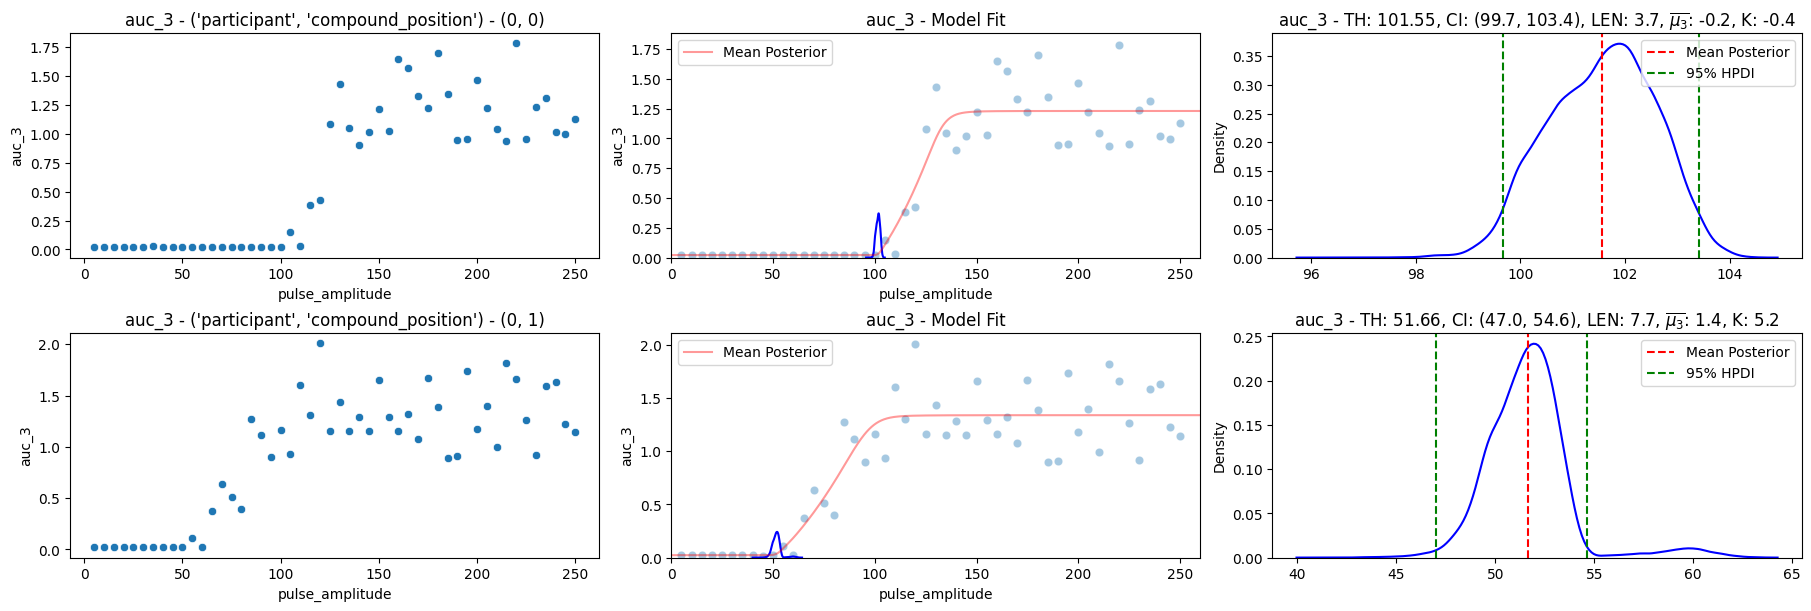

In [ ]:
model.plot(df=df, posterior_samples=posterior_samples);

#### Information Criterion

In [ ]:
numpyro_data = az.from_numpyro(mcmc)

##### Loo

In [ ]:
az.loo(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    75.41    26.79
p_loo       29.75        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       90   90.0%
 (0.5, 0.7]   (ok)          4    4.0%
   (0.7, 1]   (bad)         3    3.0%
   (1, Inf)   (very bad)    3    3.0%

##### WAIC

In [ ]:
az.waic(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    81.37    25.59
p_waic       23.80        -

There has been a warning during the calculation. Please check the results.